 # Description:
 This is unofficial colab implementation of the paper **MISC: Ultra-low Bitrate Image Semantic Compression Driven by Large Multimodal Model** (https://arxiv.org/abs/2402.16749. ).

 Main codes are from official repository (https://github.com/lcysyzxdxc/MISC ) but I modified some code so that it works on newer version of DiffBIR. And I added propmt-generation part.

 # Usage:
 To run DiffBIR, colab PRO is required. Set L4 GPU & 64GB RAM in runtime setting to run this code.

 Put your ChatGPT API key in your hidden environment variable and name it `OPENAI_AI_KEY`.

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00


In [3]:
from openai import OpenAI
from google.colab import userdata
client = OpenAI(api_key = userdata.get('OPENAI_AI_KEY'))

prompts = ["Please list three items in this image within 3 words each. For each three items, please give their detailed description in 10 words. Answer in the following format: itemname@description. make new line for each item",
          "please give overall description of this image in 50 words. generate only an informative and natural paragrah"
          ]
image_name = "kodim19.png"
image_url = "https://r0k.us/graphics/kodak/kodak/kodim19.png"
answers = []
for prompt in prompts:
  response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": prompt},
          {
            "type": "image_url",
            "image_url": {
              "url": image_url,
            },
          },
        ],
      }
    ],
    max_tokens=300,
  )
  answers.append(response.choices[0])

In [4]:
ans_text = []
for answer in answers:
  ans_text.append(answer.message.content)

In [5]:
print(ans_text)

['white lighthouse@Tall white structure, black lantern roof, maritime navigation aid.\nwhite picket fence@Short white fence, encloses property, traditional style.\nlifebuoy@Bright orange safety device, attached to white fence.', "This image captures a charming coastal scene featuring a traditional white lighthouse with a black lantern room perched at the top, indicating its role in guiding mariners. Adjacent to the lighthouse, there's a simple white building, presumably a keeper’s house or a utility structure. The property, enclosed by a quaint white picket fence which matches the buildings, also includes maritime elements like a lifebuoy and an old anchor, enhancing the nautical theme. The sky above is partly cloudy, suggesting a serene, somewhat breezy day."]


In [6]:
import pandas as pd
df = pd.DataFrame(data = [image_name], columns = ["image_name"])
print(type(ans_text[0]))
items = ans_text[0].split("\n")
assert(len(items) == 3)
item1, item1_desc = items[0].split("@")
item2, item2_desc = items[1].split("@")
item3, item3_desc = items[2].split("@")
df["item1"] = item1
df["item2"] = item2
df["item3"] = item3
df["item1_description"] = item1_desc
df["item2_description"] = item2_desc
df["item3_description"] = item3_desc

df["overall_description"] = ans_text[1]

<class 'str'>


In [7]:
df.to_csv("/content/gpt.csv")

In [8]:
%cd /content
!git clone https://github.com/tokkiwa/DiffBIR
%cd /content/DiffBIR
!mkdir weights
!pip install -q einops pytorch_lightning==1.9.5 torch==2.1.0 gradio omegaconf transformers lpips segment_anything #opencv-python
#xformer と torchのバージョンを合わせる必要がある。あとは多分うまくやってくれてるはず……
!pip install -q https://download.pytorch.org/whl/cu121/xformers-0.0.22.post7-cp310-cp310-manylinux2014_x86_64.whl
!pip install -q git+https://github.com/mlfoundations/open_clip@v2.20.0

!pip install compressai
!apt -y install -qq aria2
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lxq007/DiffBIR/resolve/main/general_full_v1.ckpt -d /content/DiffBIR/weights -o general_full_v1.ckpt
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lxq007/DiffBIR/resolve/main/general_swinir_v1.ckpt -d /content/DiffBIR/weights -o general_swinir_v1.ckpt

/content
Cloning into 'DiffBIR'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 215 (delta 43), reused 32 (delta 31), pack-reused 134
Receiving objects: 100% (215/215), 15.49 MiB | 22.53 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/DiffBIR
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 3.2 MB/s e

In [9]:

import math
import io
import torch
from torchvision import transforms
import numpy as np
import os

from PIL import Image, ImageChops

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [10]:

import sys
import os
from clip import clip
import torch
import cv2
import numpy as np
from PIL import Image
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from segment_anything import sam_model_registry, SamPredictor

preprocess =  Compose([Resize((224, 224), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])
seg_model, preprocess = clip.load("CS-ViT-B/16", device=device)
#NOTE: This model is in CLIP-surgery. Not included in clip-openai.
seg_model.eval()

100%|███████████████████████████████████████| 335M/335M [00:05<00:00, 70.0MiB/s]


CLIPSurgery(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
   

In [11]:
from skimage.transform import resize
from utils.image import wavelet_reconstruction

import shutil
def clear_directory(directory_path):
# 再帰的にディレクトリを消去する
# Recurrently delete specified directory
    for file in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file)
        if os.path.isdir(file_path):

            for root, dirs, files in os.walk(file_path):
                for file in files:
                    os.remove(os.path.join(root, file))



def to_block(img,grid=32,level=8):
# 画像を決定的にダウンサンプルする
    g_w=int(img.size[0]/grid)
    g_h=int(img.size[1]/grid)# 縦横とも 1/grid 倍する
    img_resize=img.resize((g_w, g_h))
    img_np=np.floor(np.array(img_resize)/level)*level
    img_np=img_np.astype (np.uint8)
    img_reference = Image.fromarray(img_np).resize(img.size)
    return img_reference, g_w, g_h


def divide_integer(num, n):
    quotient = num // n  # 整数除法，计算商
    remainder = num % n  # 取余数
    result = [quotient] * n  # 创建一个包含n个quotient的列表

    # 将余数平均分配给前几个数
    for i in range(remainder):
        result[i] += 1

    return result
def mask_block(mask,num=8,level=0.35):
    tmp=resize(mask, (num, num), mode='reflect')
    tmp[tmp>level]=255
    tmp[tmp<=level]=0
    rp_mat_0=np.array(divide_integer(mask.shape[0], num),dtype='int')
    rp_mat_1=np.array(divide_integer(mask.shape[1], num),dtype='int')
    return tmp.repeat(rp_mat_1,axis=1).repeat(rp_mat_0,axis=0)

def image_paddle_in(image, num=32):
    # 计算扩充后的宽度和高度
    new_width = ((image.width-1) // num + 1) * num
    new_height = ((image.height-1) // num + 1) * num

    # 创建一个新的扩充后的图像，用空值填充
    new_image = Image.new("RGB", (new_width, new_height), (0, 0, 0))

    # 将原始图像粘贴到扩充后的图像左上角
    new_image.paste(image, (0, 0))
    return new_image,image.width,image.height

def image_paddle_out(image, old_width, old_height):

    return image.crop((0,0,old_width,old_height))

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

def clip_map(img,texts,mask_num=8):
    image = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        # CLIP architecture surgery acts on the image encoder
        cv2_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        image_features = seg_model.encode_image(image)
        image_features = image_features / image_features.norm(dim=1, keepdim=True)

        # Prompt ensemble for text features with normalization
        text_features = clip.encode_text_with_prompt_ensemble(seg_model, texts, device)

        # Extract redundant features from an empty string
        redundant_features = clip.encode_text_with_prompt_ensemble(seg_model, [""], device)

        # Apply feature surgery for single text
        similarity = clip.clip_feature_surgery(image_features, text_features, redundant_features)
        similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

        mask_0=(similarity_map[0,:,:,0].cpu().numpy() * 255).astype('uint8')
        mask_1=(similarity_map[0,:,:,1].cpu().numpy() * 255).astype('uint8')
        mask_2=(similarity_map[0,:,:,2].cpu().numpy() * 255).astype('uint8')
        mask_0=Image.fromarray(mask_block(mask_0,num=mask_num))
        mask_1=Image.fromarray(mask_block(mask_1,num=mask_num))
        mask_2=Image.fromarray(mask_block(mask_2,num=mask_num))
        return mask_0,mask_1,mask_2
'''
def sr_pipe(img_reference,positive_prompt="",cfg=1.0,steps=40,res=512, cond_scale = 1.0):
    num_samples = 1 #たぶん複数枚処理するなら変える、とりあえず一枚づつに
    negative_prompt="Blurry, Low Quality"
    lq_resized = auto_resize(img_reference, res)
    x = pad(np.array(lq_resized), scale=64)
    sampler = SpacedSampler(model, var_type="fixed_small")
    control = torch.tensor(np.stack([x]) / 255.0, dtype=torch.float32, device=device).clamp_(0, 1)
    control = einops.rearrange(control, "n h w c -> n c h w").contiguous()
    control = model.preprocess_model(control)
    model.control_scales = [1] * 13
    height, width = control.size(-2), control.size(-1)
    shape = (1, 4, height // 8, width // 8)
    x_T = torch.randn(shape, device=device, dtype=torch.float32)
    cond = {
        "c_latent": [model.apply_condition_encoder(control)],
        "c_crossattn": [model.get_learned_conditioning([positive_prompt] * num_samples)]
    }
    uncond = {
        "c_latent": [model.apply_condition_encoder(control)],
        "c_crossattn": [model.get_learned_conditioning([negative_prompt] * num_samples)]
    }
    samples = sampler.sample(
            steps=steps, shape=shape, cond_img=control,
            positive_prompt=positive_prompt, negative_prompt="Blurry, Low Quality", x_T=x_T,
            cfg_scale=cfg, cond_fn=None,
            color_fix_type="wavelet"
      )
    x_samples = samples.clamp(0, 1)
    x_samples = (einops.rearrange(x_samples, "b c h w -> b h w c") * 255).cpu().numpy().clip(0, 255).astype(np.uint8)

    img_sr=Image.fromarray(x_samples[0][:,0:lq_resized.size[0],:])
    return img_sr
'''
def sr_pipe(img_reference,positive_prompt="",cfg=1.0,steps=40,res=512, cond_scale = 1.0, old_size = None):
    control_img = img_reference
    sr_scale = 1 #超解像の拡大率
    num_samples = 1 #複数枚サンプリングする。しないので1。
    #image_size = old_size
    disable_preprocess_model= False
    strength = 1.0
    cond_scale = 1.0
    use_color_fix = True
    keep_original_size = False
    negative_prompt="Blurry, Low Quality"
    sampler = SpacedSampler(model, var_type="fixed_small")

    if sr_scale != 1:
        control_img = control_img.resize(
            tuple(math.ceil(x * sr_scale) for x in control_img.size),
            Image.BICUBIC
        )
    #input size は入力サイズで、これを指定されたimage_sizeにリサイズしてから超解像を行う
    input_size = control_img.size
    #control_img = auto_resize(control_img, image_size)
    h, w = control_img.height, control_img.width
    control_img = pad(np.array(control_img), scale=64) # HWC, RGB, [0, 255]
    control_imgs = [control_img] * num_samples
    control = torch.tensor(np.stack(control_imgs) / 255.0, dtype=torch.float32, device=model.device).clamp_(0, 1)
    control = einops.rearrange(control, "n h w c -> n c h w").contiguous()
    if not disable_preprocess_model:
        control = model.preprocess_model(control)
    height, width = control.size(-2), control.size(-1)
    cond = {
        "c_latent": [model.apply_condition_encoder(control)],
        "c_crossattn": [model.get_learned_conditioning([positive_prompt] * num_samples)]
    }
    uncond = {
        "c_latent": [model.apply_condition_encoder(control)],
        "c_crossattn": [model.get_learned_conditioning([negative_prompt] * num_samples)]
    }
    model.control_scales = [strength] * 13

    shape = (num_samples, 4, height // 8, width // 8)
    print(f"latent shape = {shape}")
    x_T = torch.randn(shape, device=model.device, dtype=torch.float32)
    samples = sampler.sample(
        steps, shape, cond,
        unconditional_guidance_scale=cond_scale,
        unconditional_conditioning=uncond,
        cond_fn=None, x_T=x_T
    )
    x_samples = model.decode_first_stage(samples)
    x_samples = ((x_samples + 1) / 2).clamp(0, 1)

    # apply color correction
    if use_color_fix:
        x_samples = wavelet_reconstruction(x_samples, control)

    x_samples = (einops.rearrange(x_samples, "b c h w -> b h w c") * 255).cpu().numpy().clip(0, 255).astype(np.uint8)
    preds = []
    for img in x_samples:
        if keep_original_size:
            # remove padding and resize to input size
            img = Image.fromarray(img[:h, :w, :]).resize(input_size, Image.LANCZOS)
            preds.append(np.array(img))
        else:
            # remove padding
            preds.append(img[:h, :w, :])
    return preds

In [ ]:
#!wget https://dropbox.com/scl/fi/br0zu6a91wygs68afesyo/cheng_small.pth.tar

In [13]:
!wget -P /content/ https://r0k.us/graphics/kodak/kodak/kodim19.png

--2024-05-06 01:13:33--  https://r0k.us/graphics/kodak/kodak/kodim19.png
Resolving r0k.us (r0k.us)... 174.127.119.148
Connecting to r0k.us (r0k.us)|174.127.119.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 671476 (656K) [image/png]
Saving to: ‘/content/kodim19.png’

kodim19.png         100%[===================>] 655.74K  --.-KB/s    in 0.1s    

2024-05-06 01:13:33 (5.66 MB/s) - ‘/content/kodim19.png’ saved [671476/671476]



In [14]:
mode='net'
using_map=False

if mode=='net':
    from compressai.zoo import cheng2020_attn
    comp_net = cheng2020_attn(pretrained=True, quality = 1).to(device)
elif mode=='tuned_net':
    checkpoint_path= '/content/DiffBIR/cheng_small.pth.tar'
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    state_dict = checkpoint
    for key in ["network", "state_dict", "model_state_dict"]:
        if key in checkpoint:
            state_dict = checkpoint[key]
    arch='cheng2020-attn'
    from compressai.zoo.image import model_architectures as architectures
    model_cls = architectures[arch]
    comp_net = model_cls.from_state_dict(state_dict).eval().to(device)
elif mode=='ref':
    ref_path='./ref/example-reference.png'
    ref_bpp=0.0421
elif mode=='pixel':
    block_level=3
    block_num_min=32


mask_num=8
res=1024

import pandas as pd
df = pd.read_csv("/content/gpt.csv")

image_path='/content/kodim19.png'


img = Image.open(image_path).convert('RGB')

In [15]:
########################## Encoder ##########################

#GPT prompt processing
'''
prompt=df['prompt'][0]
prompt_list=prompt.split('\n')
prompt_list = [element for element in prompt_list if element != '']
name_0,name_1,name_2=prompt_list[0].split('.')[0].split(',')
detail_0,detail_1,detail_2=prompt_list[1],prompt_list[2],prompt_list[3]
detail_all=prompt_list[4]
'''
name_0 = df['item1'][0]
name_1 = df['item2'][0]
name_2 = df['item3'][0]
detail_0 = df['item1_description'][0]
detail_1 = df['item2_description'][0]
detail_2 = df['item3_description'][0]
detail_all = df['overall_description'][0]

mask_0,mask_1,mask_2=clip_map(img,[name_0,name_1,name_2],mask_num)


#reference
if mode=='pixel':
    old_width, old_height=img.size
    block_num=max(int(max(old_width, old_height)/16),block_num_min)
    img_reference=to_block(img,block_num,2**block_level)

    b_image=block_level*block_num**2
elif mode=='net' or mode =='tuned_net':
    img, old_width, old_height = image_paddle_in(img, 64)
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out_net = comp_net.forward(x)
    out_net['x_hat'].clamp_(0, 1)
    img_reference = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())
    img_reference = image_paddle_out(img_reference, old_width, old_height)
    b_image=compute_bpp(out_net)*img.size[0]*img.size[1]
elif mode=='ref':
    old_width, old_height=img.size
    img_reference = Image.open(ref_path).convert('RGB')
    b_image=ref_bpp*img.size[0]*img.size[1]


#############################################################

In [16]:
from utils.image import auto_resize, pad
import einops
from utils.common import instantiate_from_config, load_state_dict
from omegaconf import OmegaConf
from model.cldm import ControlLDM
from model.spaced_sampler import SpacedSampler
model: ControlLDM = instantiate_from_config(OmegaConf.load('./configs/model/cldm.yaml'))
ckpt_swinir='./weights/general_full_v1.ckpt'
#ckpt_net='./weights/cheng_small.pth.tar'


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 20 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280,

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 20 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 1024 and using 20 heads.
Se

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 173MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [17]:
load_state_dict(model, torch.load(ckpt_swinir, map_location="cpu"), strict=True)
model.freeze()
model.to(device)

ControlLDM(
  (model): DiffusionWrapper(
    (diffusion_model): ControlledUnetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=320, out_features=1280, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=1280, out_features=320, bias=True)
            )
            (out_layers): Sequential(
       

In [18]:
########################## Decoder ##########################
num_inference_steps=40
exag=1024/max(img_reference.size)
height=int(img_reference.size[1]*exag/8)*8
width=int(img_reference.size[0]*exag/8)*8

#    img_reference=img_reference.resize([width,height])
mask_0=mask_0.resize([width,height])
mask_1=mask_1.resize([width,height])
mask_2=mask_2.resize([width,height])
mask_all=Image.new("RGB", img_reference.size, (255, 255, 255))

image = img_reference

if using_map:
    b_mask=mask_num*mask_num*3
    b_word=(len(detail_0)+len(detail_1)+len(detail_2)+len(detail_all))*8
    bpp=(b_image+b_mask+b_word)/(img.size[0]*img.size[1])
    print('bpp='+str(bpp))

    image_tmp = sr_pipe(image,positive_prompt=detail_0,cfg=3.5,steps=3,res=res)
    image = ImageChops.add(ImageChops.multiply(image_tmp,mask_0.convert("RGB")),
                          ImageChops.multiply(image,Image.fromarray(255-np.array(mask_0)).convert("RGB"))
                          ).resize((old_width, old_height))
#    image.resize((old_width, old_height)).save(output_folder+'Mask0/'+image_name)

    image_tmp = sr_pipe(image,positive_prompt=detail_1,cfg=3.5,steps=3,res=res)
    image = ImageChops.add(ImageChops.multiply(image_tmp,mask_1.convert("RGB")),
                          ImageChops.multiply(image,Image.fromarray(255-np.array(mask_1)).convert("RGB"))
                          ).resize((old_width, old_height))
#    image.resize((old_width, old_height)).save(output_folder+'Mask1/'+image_name)

    image_tmp = sr_pipe(image,positive_prompt=detail_2,cfg=3.5,steps=3,res=res)
    image = ImageChops.add(ImageChops.multiply(image_tmp,mask_2.convert("RGB")),
                          ImageChops.multiply(image,Image.fromarray(255-np.array(mask_2)).convert("RGB"))
                          ).resize((old_width, old_height))
#    image.resize((old_width, old_height)).save(output_folder+'Mask2/'+image_name)

    image = sr_pipe(image,positive_prompt=detail_all,cfg=7,steps=40,res=res).resize((old_width, old_height))
#    image.resize((old_width, old_height)).save(output_folder+'SR/'+image_name)

else:
    b_word=(len(detail_all))*8
    bpp=(b_image+b_word)/(img.size[0]*img.size[1])
    print('image bit = ', b_image, 'text bit = ', b_word, 'bpp=', str(bpp))

    image = sr_pipe(image,positive_prompt=detail_all,cfg=7,steps=40,res=res,
                    old_size = (old_width, old_height))
    #output_image = image.resize((old_width, old_height))

image bit =  67095.146484375 text bit =  4312 bpp= 0.18159776429335275
latent shape = (1, 4, 96, 64)
start to sample from a given noise
Running Spaced Sampling with 40 timesteps


Spaced Sampler: 100%|██████████| 40/40 [00:08<00:00,  4.57it/s]


# Output Image (Compressed & Decompressed & Deblurred)

array([[[ 80,  92, 105],
        [ 78,  91, 107],
        [ 78,  90, 104],
        ...,
        [139, 141, 136],
        [138, 142, 140],
        [138, 140, 139]],

       [[ 78,  92, 107],
        [ 83,  96, 108],
        [ 81,  94, 105],
        ...,
        [138, 139, 137],
        [138, 140, 138],
        [137, 140, 138]],

       [[ 81,  95, 108],
        [ 82,  94, 106],
        [ 80,  92, 103],
        ...,
        [136, 138, 136],
        [137, 139, 136],
        [137, 138, 136]],

       ...,

       [[ 49,  54,  26],
        [ 47,  51,  26],
        [ 46,  50,  22],
        ...,
        [100,  84,  54],
        [ 90,  71,  43],
        [ 96,  78,  49]],

       [[ 47,  53,  24],
        [ 50,  57,  28],
        [ 55,  62,  31],
        ...,
        [ 84,  67,  40],
        [ 85,  61,  38],
        [ 99,  78,  52]],

       [[ 48,  51,  28],
        [ 49,  54,  26],
        [ 57,  61,  33],
        ...,
        [ 84,  63,  41],
        [ 79,  56,  35],
        [ 80,  62,  41]]], dtype=uint8)
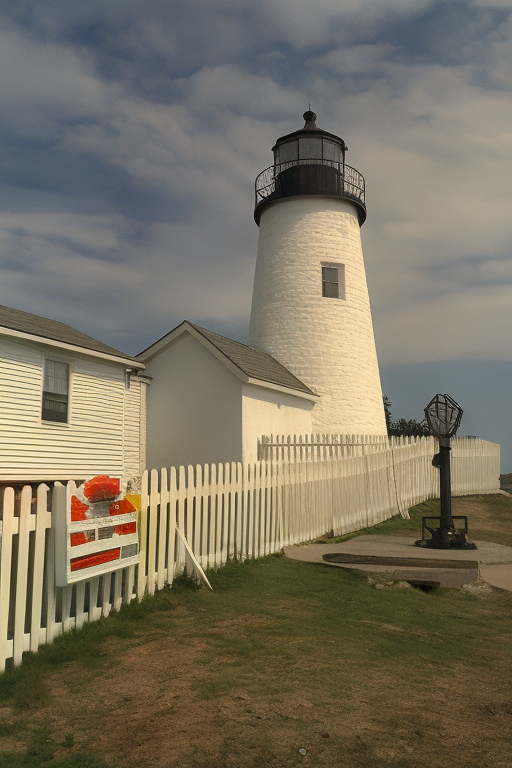

In [19]:
image[0]

# Decompressed Image (Before Deblurring)

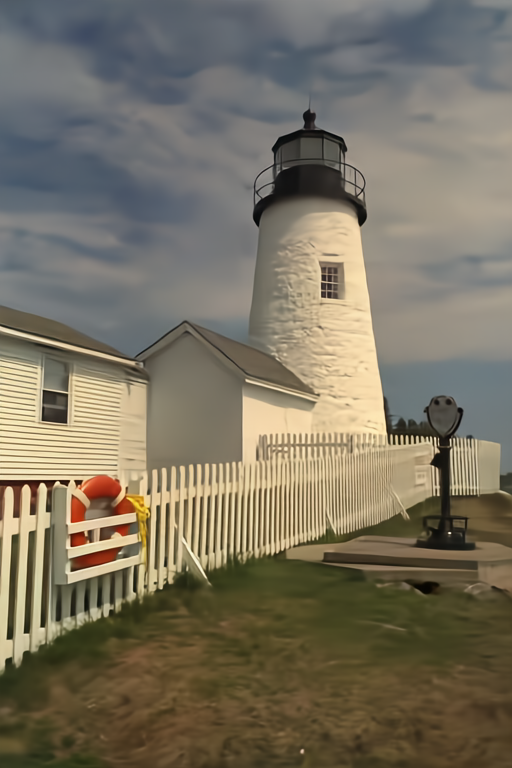

In [20]:
img_reference

# Original Image

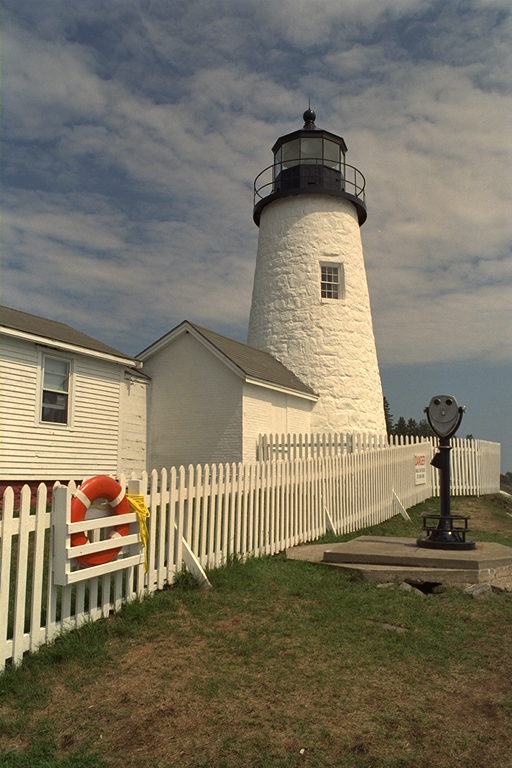

In [22]:
img

In [23]:
import torchvision.transforms.functional as TF
from lpips import LPIPS


def psnr(img0, img1):
    mse = np.mean((img0 - img1) ** 2)
    return 10 * np.log10(255 ** 2 / mse)

def lpips(img0, img1):
    # Variables im0, im1 is a PyTorch Tensor/Variable with shape Nx3xHxW
    # (N patches of size HxW, RGB images scaled in [-1,+1])
    loss_fn_alex = LPIPS(net='alex')
    img0 = (TF.to_tensor(img0) - 0.5) * 2
    img0.unsqueeze(0)

    img1 = (TF.to_tensor(img1) - 0.5) * 2
    img1.unsqueeze(0)
    # Higher means further/more different. Lower means more similar.
    return loss_fn_alex(img0, img1).item()



In [24]:
print("psnr: ", psnr(img, image[0]))
print("lpips: ", lpips(img, image[0]))

psnr:  30.772708052228293
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
lpips:  0.22787761688232422


# Better than decompressed image?

In [70]:
print("psnr: ", psnr(img, np.array(img_reference)))
print("lpips: ", lpips(img, np.array(img_reference)))

psnr:  32.06073082443483
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
lpips:  0.34790700674057007
